<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/main/12-architectures/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

In [1]:
import pickle
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import svm, metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from mpl_toolkits.axes_grid1 import AxesGrid

plt.rcdefaults()

In [2]:
# make sure the results are reproducible
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# run all computations on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running computations with %s' % torch.device(device))
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(device))

Running computations with cuda
_CudaDeviceProperties(name='NVIDIA GeForce RTX 3070', major=8, minor=6, total_memory=8191MB, multi_processor_count=46)


## MNIST

We will use the well-known MNIST dataset, again. It consists of relatively small $28 \times 28$ pixel images of digits. The goals of the dataset is to classify the digit images to the actual number that is on the image. 

In [3]:
# batch size for the dataloader
batch_size = 64

# data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, 
                   transform=transforms.ToTensor()), batch_size=batch_size, 
                   shuffle=False)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, 
                   transform=transforms.ToTensor()), batch_size=batch_size, 
                   shuffle=False)

# print statistics
print('The train data consists of %d samples' % len(train_loader.dataset))
print('The test data consists of %d samples' % len(test_loader.dataset))

100%|██████████| 9912422/9912422 [00:01<00:00, 6909863.88it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6757766.42it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

The train data consists of 60000 samples
The test data consists of 10000 samples


Here are a few examples of the data, the corresponding label is on top of each image. 

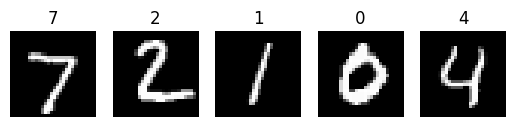

In [4]:
# visualize the data
n = 5
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(test_loader.dataset[i][0].numpy()[0, ...], cmap='gray')
    plt.title(test_loader.dataset[i][1])
    plt.axis('off')
plt.show()

## Building an autoencoder

Now, we have to implement the autoencoder and train it. Let's start by defining the architecture. 

Let's build a straightforward autoencoder with a single hidden layer. Not that every pixel in the image corresponds to an input dimension, i.e. the input and output of the autoencoder will be $28 \times 28$ dimensional and images will have to be reshaped in vector format. Implement the following architecture: 
- The first layer (encoder) will be a fully connected layer with sigmoid activation that transforms the input features to a 64 dimensional (hidden) feature vector representation. 
- The second layer (decoder) is another FC that transforms the hidden representation to the original input dimensions. 

In [5]:
dim_hidden = 64

In [6]:
class AutoEncoder(nn.Module):
    
    def __init__(self, dim_input, dim_hidden):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(in_features=dim_input, out_features=dim_hidden), nn.Sigmoid())
        self.decoder = nn.Sequential(nn.Linear(in_features=dim_hidden, out_features=dim_input), nn.Sigmoid())

    def forward(self, x):
        h = self.encoder(x)
        x_ = self.decoder(h)
        return x_

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


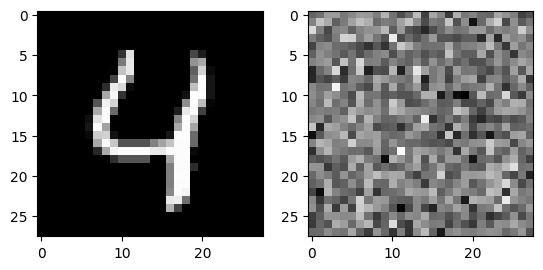

In [7]:
net_ae = AutoEncoder(28*28, dim_hidden)
print(net_ae)

# propagate a sample
x = test_loader.dataset[i][0].view(-1, 28 * 28)
x_ = net_ae(x)

# show the result
plt.subplot(1, 2, 1)
plt.imshow(x.view(28, 28).numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(x_.view(28, 28).detach().numpy(), cmap='gray')
plt.show()

Obviously, the networks is generating random noise right now, as it has not yet been trained. 

## Training an autoencoder

In [8]:
def train_epoch(net, loader, optimizer, criterion, device): 
    net.train()
    loss_avg = 0
    for x, _ in loader:
        # construct a batch
        x = x.view(-1, 28*28).to(device)

        # zero the gradients
        optimizer.zero_grad()

        # forward propagation
        x_ = net(x)

        # compute the loss
        loss = criterion(x_, x)

        # backward propagation
        loss.backward()

        # update the weights
        optimizer.step()

        loss_avg += loss.item()
    loss_avg = loss_avg / len(loader)
    return loss_avg

In [9]:
def test_epoch(net, loader, criterion, device): 
    net.eval()
    loss_avg = 0
    for x, _ in loader:
        # construct a batch
        x = x.view(-1, 28*28).to(device)

        # forward propagation
        x_ = net(x)

        # compute the loss
        loss = criterion(x_, x)

        loss_avg += loss.item()
    loss_avg = loss_avg / len(loader)
    return loss_avg

In [10]:
def train(net, train_loader, test_loader, optimizer, epochs, criterion, device): 
    train_losses = np.zeros((epochs))
    test_losses = np.zeros((epochs))
    for epoch in range(epochs):
        train_losses[epoch] = train_epoch(net, train_loader, optimizer, criterion, device)
        test_losses[epoch] = test_epoch(net, test_loader, criterion, device)
        print("Epoch %d/%d: Train loss = %.4f - Test loss = %.4f" 
              % (epoch + 1, epochs, train_losses[epoch], test_losses[epoch]))
    
    return train_losses, test_losses

In [11]:
lr = 1e-2
weight_decay = 1e-5
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net_ae = net_ae.to(device)

optimizer = optim.Adam(net_ae.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.MSELoss()

In [12]:
train_loss, test_loss = train(net_ae, train_loader, test_loader, 
                              optimizer, epochs, criterion, device)

Epoch 1/10: Train loss = 0.0365 - Test loss = 0.0265
Epoch 2/10: Train loss = 0.0245 - Test loss = 0.0246
Epoch 3/10: Train loss = 0.0230 - Test loss = 0.0237
Epoch 4/10: Train loss = 0.0222 - Test loss = 0.0234
Epoch 5/10: Train loss = 0.0218 - Test loss = 0.0232
Epoch 6/10: Train loss = 0.0216 - Test loss = 0.0232
Epoch 7/10: Train loss = 0.0215 - Test loss = 0.0232
Epoch 8/10: Train loss = 0.0214 - Test loss = 0.0232
Epoch 9/10: Train loss = 0.0214 - Test loss = 0.0232
Epoch 10/10: Train loss = 0.0213 - Test loss = 0.0232


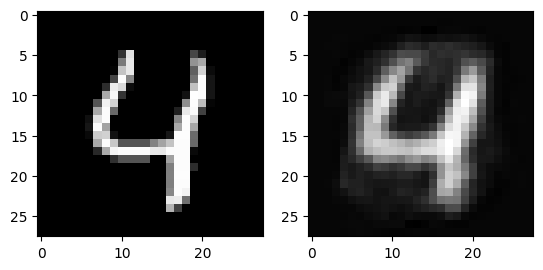

In [13]:
# propagate a sample
net_ae.eval()
x = test_loader.dataset[i][0].view(-1, 28 * 28).to(device)
x_ = net_ae(x)

# show the result
plt.subplot(1, 2, 1)
plt.imshow(x.view(28, 28).cpu().numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(x_.view(28, 28).cpu().detach().numpy(), cmap='gray')
plt.show()

The network is able to reconstruct the data fairly decent. The result is slightly blurry, you may play around the loss function. 

## Latent Space Interpolation

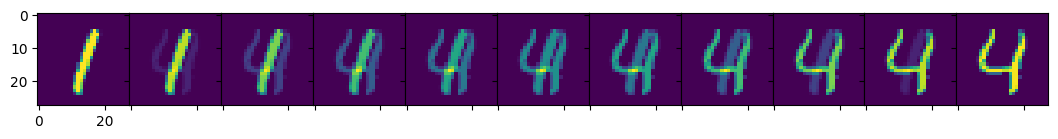

In [14]:
# pick two examples from the dataset
a = test_loader.dataset[i][0].view(28, 28)
b = test_loader.dataset[i+1][0].view(28, 28)

# build a grid
fig = plt.figure(figsize=(60,5))
grid = AxesGrid(fig, 141, nrows_ncols=(1, 11),
                axes_pad=0.00, label_mode="1")

# interpolate between images
for k in range(11):
    z = k/10. * a + (1. - k/10.) * b
    im = grid[k].imshow(z, interpolation="nearest")

Now let's do nearly the same thing, but in a latent space, picking up the low-dimentional representation provided by the encoder.

C:\Users\BRINE\AppData\Local\Temp\ipykernel_20748\1902769530.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(a.view(-1, 28 * 28).to(device))
C:\Users\BRINE\AppData\Local\Temp\ipykernel_20748\1902769530.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(b.view(-1, 28 * 28).to(device))


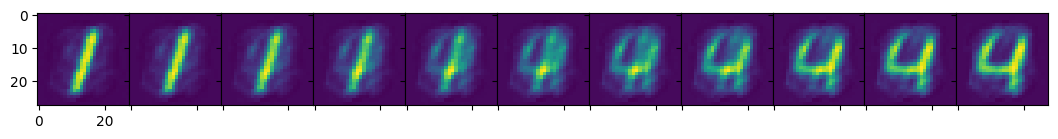

In [15]:
# get low-dimentional representations
x = torch.tensor(a.view(-1, 28 * 28).to(device))
a_emb = net_ae.encoder(x)   
x = torch.tensor(b.view(-1, 28 * 28).to(device))
b_emb = net_ae.encoder(x) 

fig = plt.figure(figsize=(60,5))
grid = AxesGrid(fig, 141, nrows_ncols=(1, 11),
                axes_pad=0.00, label_mode="1",)

for k in range(11):
    # interpolate in latent space
    z_emb = k/10. * a_emb + (1. - k/10.) * b_emb
    # use the latent code to decode the results
    z = net_ae.decoder(z_emb)
    im = grid[k].imshow(z.cpu().data.numpy().reshape(28,28), interpolation="nearest")

## Clustering with autoencoders

We can cluster data with an autoencoder model, the most straight-forward approach is to cluster the data in the encoded space, e.g. using k-means clustering. 

In [16]:
def compute_embeddings(net, loader):
    net.eval()
    embeddings = np.zeros((len(loader.dataset), dim_hidden))
    b = 0
    for x, _ in loader:
        x = x.view(-1, 28*28).to(device)
        h = net.encoder(x).cpu().detach().numpy()
        embeddings[b: b+len(h)] = h
        b += len(h)
    return embeddings

In [17]:
# compute the embeddings of the autoencoder on the test set
h = compute_embeddings(net_ae, test_loader)

# cluster the embeddings
kmeans = KMeans(n_clusters=10, random_state=seed).fit(h)
predictions = kmeans.labels_
labels = test_loader.dataset.targets.numpy()

# evaluate
# ars_ae = adjusted_rand_score(labels, predictions)
# print('Adjusted rand score: %.3f' % ars_ae)

C:\PYTHON\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The following code will compare the true labels and the clustering results. Note that the colors do not necessarily correspond to the same cluster. 

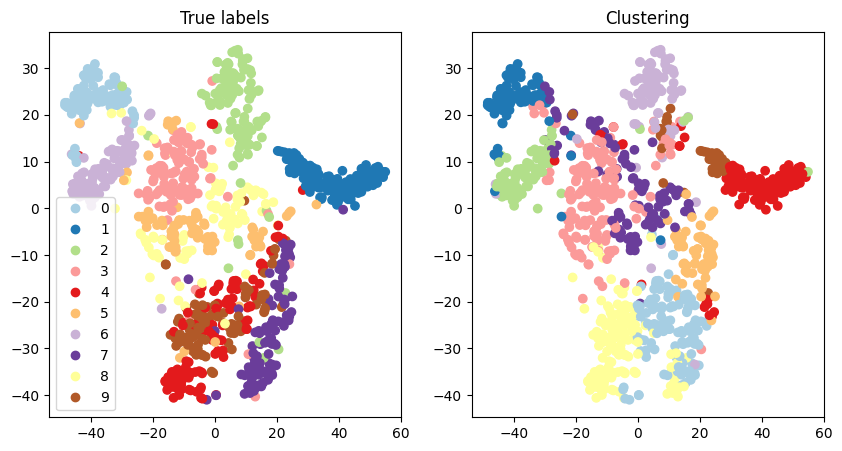

In [18]:
# reduce the dimensionality of the hidden representations
ld = TSNE(n_components=2, random_state=seed).fit_transform(h[:1000])

# visualize the reduced representations and label each sample
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
scatter = plt.scatter(ld[:, 0], ld[:, 1], c=labels[:1000], cmap='Paired')
plt.legend(handles=scatter.legend_elements()[0], labels=range(10))
plt.title('True labels')
plt.subplot(1, 2, 2)
scatter = plt.scatter(ld[:, 0], ld[:, 1], c=predictions[:1000], cmap='Paired')
plt.title('Clustering')
plt.show()

## Feature Importance 

Within the encoder, there are connections to each pixel for each hidden variable. In other words, we can visualize which pixels are important to activate a particular hidden variable. 

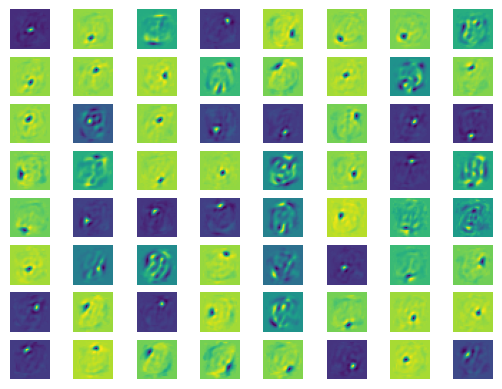

In [19]:
# extract the matrix parameters
w = list(net_ae.encoder.parameters())[0]
# visualize the features
k = 8
for i in range(k):
    for j in range(k):
        plt.subplot(k, k, i*k+j+1)
        plt.imshow(w[i*k+j,:].view(28, 28).cpu().detach().numpy())
        plt.axis('off')
plt.show()

## Semi-supervised classification

Semi-supervised classification aims to use large amounts of unlabeled data and a limited amount of labeled data for maximum classification performance. We will see that the extracted features of an autoencoder can serve as suitable features for classification. Moreover, you can use some `sklearn` model to perform the classification, as NNs seems like overkill here. 

In [20]:
def train_svm(x_train, y_train, n):
    clf = svm.SVC()
    clf.fit(x_train[:n], y_train[:n])
    return clf

def test_svm(clf, x_test, y_test):
    predicted = clf.predict(x_test)
    acc = metrics.accuracy_score(y_test, predicted)
    return acc

In [21]:
# compute the embeddings of the autoencoder on the train and test set
h_train = compute_embeddings(net_ae, train_loader)
h_test = compute_embeddings(net_ae, test_loader)

# train and test an SVM for a varying amount of training data
n_train_min = 10
n_train_max = 200
n_train_step = 10
n_samples = np.arange(n_train_min, n_train_max, n_train_step)
accuracies_ae = np.zeros((len(n_samples)))
accuracies_bl = np.zeros((len(n_samples)))
for j in range(len(n_samples)):
    # autoencoder
    clf = train_svm(h_train, train_loader.dataset.targets.numpy(), n_samples[j])
    accuracies_ae[j] = test_svm(clf, h_test, test_loader.dataset.targets.numpy())
    # baseline
    clf = train_svm(train_loader.dataset.data.numpy().reshape((-1, 28*28)), 
                    train_loader.dataset.targets.numpy(), n_samples[j])
    accuracies_bl[j] = test_svm(clf, test_loader.dataset.data.numpy().reshape((-1, 28*28)), 
                                test_loader.dataset.targets.numpy())

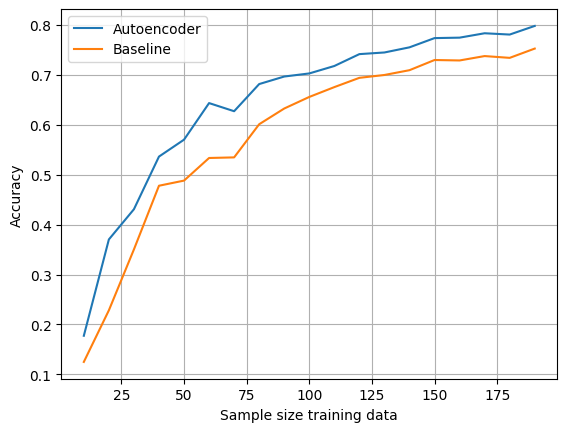

In [22]:
plt.plot(n_samples, accuracies_ae)
plt.plot(n_samples, accuracies_bl)
plt.xlabel('Sample size training data')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(('Autoencoder', 'Baseline'))
plt.show()